In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as data_utils

import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

import numpy as np
from numpy import arange
import random
import pandas as pd
# import sklearn
# from sklearn.model_selection import train_test_split

C:\Users\huyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters

In [2]:
epochs = 30
batch_size = 32
checkpoint_p = './asl_cnn_aug.pth'

## Loading data

In [3]:

train_p = '../data/asl_data/sign_mnist_train.csv'
test_p = '../data/asl_data/sign_mnist_valid.csv'

train_data = pd.read_csv(train_p,  sep=',')
test_data = pd.read_csv(test_p,  sep=',')
print(f'Train set shape: {train_data.shape}. Test set shape: {test_data.shape}')

Train set shape: (27455, 785). Test set shape: (7172, 785)


In [4]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


#### Exploring the class labels to consider encoding them if neccessary

In [5]:
uniq_classes = set(list(train_data['label'])+list(test_data['label']))
n_classes = len(uniq_classes)
print('classes: ', uniq_classes)
print('number of classes: ', n_classes)


classes:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
number of classes:  24


## Preparing data

In [7]:
y_train = train_data['label']
y_val = test_data['label']
del train_data['label']
del test_data['label']

X_train = train_data.values.reshape(-1,28,28,1)
X_val = test_data.values.reshape(-1,28,28,1)

print(f'X_train shape: {X_train.shape}. y_train shape: {y_train.shape}')
print(f'X_test shape: {X_val.shape}. y_test shape: {y_val.shape}')

X_train shape: (27455, 28, 28, 1). y_train shape: (27455,)
X_test shape: (7172, 28, 28, 1). y_test shape: (7172,)


### Showing some image and label examples

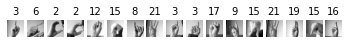

In [10]:
# Showing image examples
def show_imgs(feature_lists, labels):
    for i, (features, label) in enumerate(zip (feature_lists, labels)):
        image = features.reshape(28, 28)
        plt.subplot(1, len(labels), i+1)
        plt.title(label, fontdict={'fontsize': 10})
        plt.axis('off')
        plt.imshow(image, cmap='gray')

show_imgs(X_train[:17], y_train[:17])

### Loading data to Dataset and Dataloader object
- Data augumentation
- Data normalization

In [12]:
class SignALSDataset():
    def __init__(self, X, Y) -> None:
        super(SignALSDataset, self).__init__()
        self.X = np.array(X, dtype=np.uint8)
        self.Y = Y
    
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        else:
            idx = idx
        # Applying data augumentation methods
        transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.RandomRotation(10), # randomly rotate images
                                        transforms.RandomResizedCrop(28, scale=(0.8, 1.2)),
                                        transforms.RandomAffine(0,translate=(0.1, 0.1)), # randomly shift images horizontally and vertically
                                        transforms.RandomHorizontalFlip(0.1), # randomly flip images horizontally
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5,), (0.5,))]) # normalizing the data
        trans_x = transform(self.X[idx]).float()
        y = torch.tensor(self.Y[idx], dtype = torch.long)
        return trans_x, y
        
# passing data to the customized dataset class we created
train_datatensor = SignALSDataset(X_train, y_train)
val_datatensor = SignALSDataset(X_val, y_val)

# loading datasets to pytorch dataloader object
train_dataloader = DataLoader(train_datatensor, sampler = torch.utils.data.RandomSampler(train_datatensor), batch_size=batch_size )
val_dataloader = DataLoader(val_datatensor, sampler = torch.utils.data.SequentialSampler(val_datatensor), batch_size=batch_size )



In [13]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


## Creating model

In [14]:
class CNNNet(nn.Module):
    def __init__(self, n_classes) -> None:
        super(CNNNet, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=75, kernel_size=3, stride=1)
        self.batchnorm1 = nn.BatchNorm2d(75)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=75, out_channels=50, kernel_size=3, stride=1)
        self.batchnorm2 = nn.BatchNorm2d(50)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=50, out_channels=25, kernel_size=3, stride=1)
        self.batchnorm3 = nn.BatchNorm2d(25)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride=1)

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)

        self.fc1 = nn.Linear(2*2*25, 512)
        self.fc2 = nn.Linear(512, self.n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # print('input x', x.size())
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.pool1(x)
        # print('after block 1', x.size())

        x = F.relu(self.conv2(x))
        x = self.dropout1(x)
        x = self.batchnorm2(x)
        x = self.pool2(x)
        # print('after block 2', x.size())

        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.pool3(x)
        # print('after block 3', x.size())

        x = x.view(-1,2*2*25 )
        # print('after flattening', x.size())

        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return self.softmax(x)


model= CNNNet(n_classes = n_classes)
print(model)

CNNNet(
  (conv1): Conv2d(1, 75, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(75, 50, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(50, 25, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=100, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=24, bias=True)
  (softmax): Softmax(dim=1)
)


In [15]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

## Training model

In [16]:
def get_accuracy (y_true, y_pred):
    return (y_pred == y_true).sum().item()/len(y_true)

def train_fn(data_loader, model, optimizer, device):
    model.train()
    final_loss = 0.0
    for i, data in enumerate(tqdm(data_loader, total = len(data_loader))):
        # get input, and send to device
        inputs, labels = data[0].to(device), data[1].to(device) #, torch.float, , dtype=torch.int64
        # zero the gradient
        optimizer.zero_grad()

        # forward
        outputs = model(inputs) 
        _, pred_labels = torch.max(outputs.data, 1)
        loss = loss_fn(outputs, labels)

        # backward
        loss.backward()
        optimizer.step()
        
        # print loss every 1000 steps
        if (i+1) % 1000 == 0:
            print(f'Step [{i+1}/{len(data_loader)}]: Loss = {loss.item()}, Accuracy = {get_accuracy(labels, pred_labels)}')

        # save loss
        final_loss +=loss.item()
    return final_loss/len(data_loader)


def eval_fn(data_loader, model):
    model.eval()
    total = 0
    correct = 0
    final_loss = 0.0
    predictions = []
    with torch.no_grad():
        for data in tqdm(data_loader, total = len(data_loader)):
            inputs, labels = data
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            final_loss +=loss.item()

            _, pred_labels = torch.max(outputs.data, 1)
            predictions.append(pred_labels)
            total+= 1 
            correct+= get_accuracy(labels, pred_labels)
            # print(f'correct / total: {correct} / {total}')

    return final_loss/len(data_loader), correct / total, predictions

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)    

train_loss_values, validation_loss_values = [], []
best_loss = np.inf

for epoch in range(epochs):
    train_loss = train_fn(train_dataloader, model, optimizer, device)
    train_loss_values.append(train_loss)
    
    val_loss, val_accuracy, _ = eval_fn(val_dataloader, model)
    validation_loss_values.append(val_loss)

    # saving the best model
    if val_loss < best_loss:
        torch.save(model, checkpoint_p)
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Epoch {epoch+1}/{epochs}: Train loss = {train_loss}, Validation loss = {val_loss}, Validation accuracy: {val_accuracy:.4f}')




100%|██████████| 225/225 [00:20<00:00, 11.09it/s]


Epoch 1/30: Train loss = 3.094260737612531, Validation loss = 3.0363455549875895, Validation accuracy: 0.2122


100%|██████████| 225/225 [00:20<00:00, 10.94it/s]


Epoch 2/30: Train loss = 2.9470553676009454, Validation loss = 2.944148959053887, Validation accuracy: 0.3353


100%|██████████| 225/225 [00:19<00:00, 11.61it/s]


Epoch 3/30: Train loss = 2.8121697021808933, Validation loss = 2.759985591040717, Validation accuracy: 0.5236


100%|██████████| 225/225 [00:18<00:00, 12.22it/s]


Epoch 4/30: Train loss = 2.711581935415735, Validation loss = 2.6756829675038656, Validation accuracy: 0.5928


100%|██████████| 225/225 [00:19<00:00, 11.66it/s]


Epoch 5/30: Train loss = 2.662863347358081, Validation loss = 2.631622765858968, Validation accuracy: 0.6361


100%|██████████| 225/225 [00:19<00:00, 11.34it/s]


Epoch 6/30: Train loss = 2.6155152921076423, Validation loss = 2.6082603475782604, Validation accuracy: 0.6610


100%|██████████| 225/225 [00:21<00:00, 10.40it/s]


Epoch 7/30: Train loss = 2.5952779037969096, Validation loss = 2.5949682235717773, Validation accuracy: 0.6669


100%|██████████| 225/225 [00:21<00:00, 10.45it/s]


Epoch 8/30: Train loss = 2.58398688228536, Validation loss = 2.5762350580427382, Validation accuracy: 0.6869


100%|██████████| 225/225 [00:20<00:00, 11.02it/s]


Epoch 9/30: Train loss = 2.56513659103767, Validation loss = 2.546833562850952, Validation accuracy: 0.7175


100%|██████████| 225/225 [00:18<00:00, 12.05it/s]


Epoch 10/30: Train loss = 2.5360597669383584, Validation loss = 2.5476438204447427, Validation accuracy: 0.7147


100%|██████████| 225/225 [00:19<00:00, 11.66it/s]


Epoch 11/30: Train loss = 2.529300661075921, Validation loss = 2.534575595855713, Validation accuracy: 0.7254


100%|██████████| 225/225 [00:20<00:00, 11.11it/s]


Epoch 12/30: Train loss = 2.5212824202917674, Validation loss = 2.5264206875695123, Validation accuracy: 0.7294


100%|██████████| 225/225 [00:18<00:00, 11.86it/s]


Epoch 13/30: Train loss = 2.513968917595479, Validation loss = 2.5218206893073187, Validation accuracy: 0.7336


100%|██████████| 225/225 [00:20<00:00, 10.81it/s]


Epoch 14/30: Train loss = 2.509839059033872, Validation loss = 2.5166983879937064, Validation accuracy: 0.7394


100%|██████████| 225/225 [00:17<00:00, 12.56it/s]


Epoch 15/30: Train loss = 2.50547425257854, Validation loss = 2.5142481994628905, Validation accuracy: 0.7429


100%|██████████| 225/225 [00:18<00:00, 12.44it/s]


Epoch 16/30: Train loss = 2.503545129493678, Validation loss = 2.5113956483205158, Validation accuracy: 0.7436


100%|██████████| 225/225 [00:18<00:00, 11.94it/s]


Epoch 17/30: Train loss = 2.499929419486395, Validation loss = 2.505719272825453, Validation accuracy: 0.7503


100%|██████████| 225/225 [00:19<00:00, 11.83it/s]


Epoch 18/30: Train loss = 2.500598046885226, Validation loss = 2.5085495524936254, Validation accuracy: 0.7462


100%|██████████| 225/225 [00:18<00:00, 12.47it/s]


Epoch 19/30: Train loss = 2.4964293349872935, Validation loss = 2.5041620710160997, Validation accuracy: 0.7500


100%|██████████| 225/225 [00:20<00:00, 10.80it/s]


Epoch 20/30: Train loss = 2.497383036813536, Validation loss = 2.5080119694603815, Validation accuracy: 0.7454


100%|██████████| 225/225 [00:21<00:00, 10.49it/s]


Epoch 21/30: Train loss = 2.4949231156102427, Validation loss = 2.5016170734829375, Validation accuracy: 0.7512


100%|██████████| 225/225 [00:21<00:00, 10.36it/s]


Epoch 22/30: Train loss = 2.491740292602486, Validation loss = 2.498906643125746, Validation accuracy: 0.7553


100%|██████████| 225/225 [00:23<00:00,  9.51it/s]


Epoch 23/30: Train loss = 2.490147470316409, Validation loss = 2.496273842917548, Validation accuracy: 0.7557


100%|██████████| 225/225 [00:17<00:00, 13.03it/s]


Epoch 24/30: Train loss = 2.4891397022145054, Validation loss = 2.5017937321133084, Validation accuracy: 0.7501


100%|██████████| 225/225 [00:16<00:00, 13.38it/s]


Epoch 25/30: Train loss = 2.489838604048971, Validation loss = 2.4982877847883436, Validation accuracy: 0.7542


100%|██████████| 225/225 [00:16<00:00, 13.68it/s]


Epoch 26/30: Train loss = 2.4869512225086594, Validation loss = 2.4972355429331463, Validation accuracy: 0.7549


100%|██████████| 225/225 [00:16<00:00, 13.66it/s]


Epoch 27/30: Train loss = 2.485259590449033, Validation loss = 2.4965972910987007, Validation accuracy: 0.7546


100%|██████████| 225/225 [00:18<00:00, 12.17it/s]


Epoch 28/30: Train loss = 2.484316521313363, Validation loss = 2.4928802511427137, Validation accuracy: 0.7581


100%|██████████| 225/225 [00:22<00:00, 10.12it/s]


Epoch 29/30: Train loss = 2.483237259037845, Validation loss = 2.4872248469458684, Validation accuracy: 0.7662


100%|██████████| 225/225 [00:15<00:00, 14.11it/s]

Epoch 30/30: Train loss = 2.4623290005819505, Validation loss = 2.4733917395273846, Validation accuracy: 0.7808


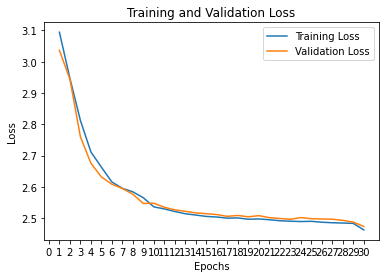

In [19]:

# Visualize the loss 
epochs = range(1, 31)
plt.plot(epochs, train_loss_values, label='Training Loss')
plt.plot(epochs, validation_loss_values, label='Validation Loss')
 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 31, 1))
 
plt.legend(loc='best')
plt.show()